In [56]:
#DATA MANIPULATING
import numpy as np
import pandas as pd

#VISUALIZATION TOOLS
import matplotlib.pyplot as plt
import seaborn as sns

#TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split

# MODELLING
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.base import clone
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.base import clone
import time

# DEBUGGING.
import sys

# WARNINGS.
from warnings import filterwarnings
filterwarnings('ignore')

#IMPORT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [241]:
df = pd.read_csv("/content/drive/MyDrive/Churn_prediction/Data/Churn_Modelling.csv")

In [242]:
X = df.drop(columns=['Exited'])
y = df['Exited'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data cleaning and preprocessing

In [279]:
def DfPrepPipeline(df):
    # Add new features
    df['BalanceSalaryRatio'] = (df.Balance/df.EstimatedSalary)
    df['TenureByAge'] = df.Tenure/(df.Age)
    df['CreditScoreGivenAge'] = df.CreditScore/(df.Age)

    # Let's consider the difference between maximum age and current age as a proxy for customer lifetime.
    max_age = df['Age'].max()
    df['CustomerLifetimeDuration'] = max_age - df['Age']

    # Average Number of Transactions per Month
    # Let's calculate the average number of transactions per month since the customer joined.
    df['AvgTransactionsPerMonth'] = df['NumOfProducts'] / df['CustomerLifetimeDuration']

    # Credit Utilization
    df['CreditUtilization'] = df['Balance'] / df['CreditScore']

    # Average Monthly Balance
    df['AvgMonthlyBalance'] = df['Balance'] / df['CustomerLifetimeDuration']

    # Reorder the columns
    continuous_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary',
                       'BalanceSalaryRatio', 'TenureByAge', 'CreditScoreGivenAge',
                       'CustomerLifetimeDuration', 'AvgTransactionsPerMonth', 'CreditUtilization',
                       'AvgMonthlyBalance']

    cat_vars = ['HasCrCard','IsActiveMember',"Geography", "Gender"]
    df = df[continuous_vars + cat_vars]

    # One hot encode the categorical variables
    df = pd.get_dummies(df, columns = ["Gender"], drop_first=True)
    df = pd.get_dummies(df, columns = ["Geography"])

    minVec = df[continuous_vars].min().copy()
    maxVec = df[continuous_vars].max().copy()

    # MinMax scaling coontinuous variables based on min and max from the train data
    df[continuous_vars] = (df[continuous_vars]-minVec)/(maxVec-minVec)

    df['TenureByAge'].fillna(0, inplace = True)
    df['CreditScoreGivenAge'].fillna(0, inplace = True)
    df['AvgTransactionsPerMonth'].fillna(0, inplace = True)
    df['AvgMonthlyBalance'].fillna(0, inplace = True)

    return df

In [280]:
X_train_prepared = DfPrepPipeline(X_train)
X_test_prepared = DfPrepPipeline(X_test)

In [281]:
print(X_train_prepared.shape)
print(X_test_prepared.shape)

(8000, 19)
(2000, 19)


# Model training, comparison, selection and tuning

- In this stage, my aim is to compare the performances of different models. To achieve this, I will employ stratified k-fold cross-validation to train each model and assess their ROC-AUC scores. Given the imbalanced nature of the target variable, accuracy is an unsuitable metric. Stratified k-fold cross-validation will address this issue by preserving the target class proportions in each fold.

- K-fold cross-validation is a machine learning technique that assesses a model's performance by dividing the dataset into K subsets, using K-1 for training and one for testing in an iterative manner. This approach helps estimate a model's generalization ability, mitigating the risk of overfitting and providing more reliable performance metrics.

- My goal here is to identify the best-performing model for subsequent hyperparameter tuning. To accomplish this, I will evaluate the models based on the highest average ROC-AUC validation scores and consider the trade-off between bias and variance.

- Once a model is selected, I will proceed with hyperparameter tuning. Hyperparameter tuning involves the selection of optimal hyperparameters for a machine learning model. These hyperparameters are set before the model is trained and directly impact its performance but are not learned from the data

In [283]:
def evaluate_models_cv(models, X_train, y_train):
    '''
    Evaluate multiple machine learning models using stratified k-fold cross-validation (the stratified k-fold is useful for dealing with target imbalancement).

    This function evaluates a dictionary of machine learning models by training each model on the provided training data
    and evaluating their performance using stratified k-fold cross-validation. The evaluation metric used is ROC-AUC score.

    Args:
        models (dict): A dictionary where the keys are model names and the values are instantiated machine learning model objects.
        X_train (array-like): The training feature data.
        y_train (array-like): The corresponding target labels for the training data.

    Returns:
        pd.DataFrame: A DataFrame containing the evaluation results for each model, including their average validation scores
                  and training scores.

    Raises:
        CustomException: If an error occurs while evaluating the models.

    '''

    try:
        # Stratified KFold in order to maintain the target proportion on each validation fold - dealing with imbalanced target.
        n_folds = 5
        stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

        # Dictionaries with validation and training scores of each model for plotting further.
        models_val_scores = dict()
        models_train_scores = dict()

        for model in models:
            # Getting the model object from the key with his name.
            model_instance = models[model]

            # Measuring training time.
            start_time = time.time()

            # Fitting the model to the training data.
            model_instance.fit(X_train, y_train)

            end_time = time.time()
            training_time = end_time - start_time

            # Make predictions on training data and evaluate them.
            y_train_pred = model_instance.predict(X_train)
            train_score = roc_auc_score(y_train, y_train_pred)

            # Evaluate the model using k-fold cross validation, obtaining a robust measurement of its performance on unseen data.
            val_scores = cross_val_score(model_instance, X_train, y_train, scoring='roc_auc', cv=stratified_kfold)
            avg_val_score = val_scores.mean()
            val_score_std = val_scores.std()

            # Adding the model scores to the validation and training scores dictionaries.
            models_val_scores[model] = avg_val_score
            models_train_scores[model] = train_score

            # Printing the results.
            print(f'{model} results: ')
            print('-'*50)
            print(f'Training score: {train_score}')
            print(f'Average validation score: {avg_val_score}')
            print(f'Standard deviation: {val_score_std}')
            print(f'Training time: {round(training_time, 5)} seconds')
            print()

        # Plotting the results.
        print('Plotting the results: ')

        # Converting scores to a dataframe
        val_df = pd.DataFrame(list(models_val_scores.items()), columns=['Model', 'Average Val Score'])
        train_df = pd.DataFrame(list(models_train_scores.items()), columns=['Model', 'Train Score'])
        eval_df = val_df.merge(train_df, on='Model')

        # Plotting each model and their train and validation (average) scores.
        plt.figure(figsize=(15, 6))
        width = 0.35

        x = np.arange(len(eval_df['Model']))

        val_bars = plt.bar(x - width/2, eval_df['Average Val Score'], width, label='Average Validation Score', color='#66c2a5')
        train_bars = plt.bar(x + width/2, eval_df['Train Score'], width, label='Train Score', color='#fc8d62')

        plt.xlabel('Model')
        plt.ylabel('ROC-AUC Score')
        plt.title('Models Performances')
        plt.xticks(x, eval_df['Model'], rotation=45)

        # Add scores on top of each bar
        for bar in val_bars + train_bars:
            height = bar.get_height()
            plt.annotate('{}'.format(round(height, 2)),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

        plt.legend()
        plt.tight_layout()
        plt.show()

        return eval_df

    except Exception as e:
      print(f"An unexpected error occurred: {e}")

In [284]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear SVM': LinearSVC(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

Logistic Regression results: 
--------------------------------------------------
Training score: 0.591491943639183
Average validation score: 0.766797969777812
Standard deviation: 0.020171621426536265
Training time: 0.07139 seconds

Linear SVM results: 
--------------------------------------------------
Training score: 0.5695009197638471
Average validation score: 0.7670185204803961
Standard deviation: 0.02017276959853691
Training time: 0.13152 seconds

SVM results: 
--------------------------------------------------
Training score: 0.6323068255145381
Average validation score: 0.8027867399909467
Standard deviation: 0.018610028711204415
Training time: 2.03496 seconds

K-Nearest Neighbors results: 
--------------------------------------------------
Training score: 0.7122867929616395
Average validation score: 0.7447311015014784
Standard deviation: 0.017642079299084207
Training time: 0.00545 seconds

Random Forest results: 
--------------------------------------------------
Training score: 1

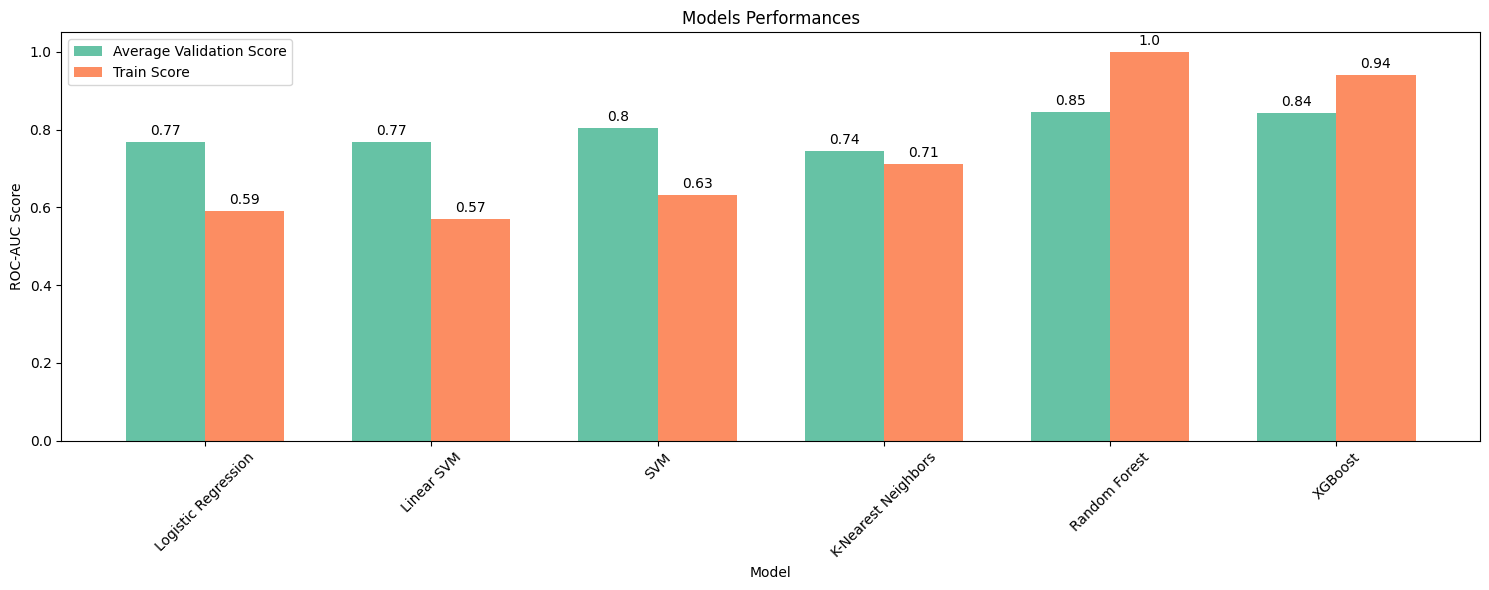

In [285]:
eval_df = evaluate_models_cv(models, X_train_prepared, y_train)

In [286]:
eval_df.sort_values(['Average Val Score'], ascending=False)

,Model,Average Val Score,Train Score
4,Random Forest,0.845202,1.000000
5,XGBoost,0.841851,0.940533
2,SVM,0.802787,0.632307
1,Linear SVM,0.767019,0.569501
0,Logistic Regression,0.766798,0.591492
3,K-Nearest Neighbors,0.744731,0.712287


I will assess the XGBoost model for hyperparameter tuning and final model evaluation. This decision is based on their performance, with the XGBoost exhibiting the highest average validation ROC-AUC score.

## XGBoost model

### Hyperparameter tuning:


Since I plan to fine-tune the XGBoost model, I will not be utilizing GridSearchCV.

**Why not opt for grid search?**

- Grid search CV, while a common approach for hyperparameter tuning, may not be the best choice for XGBoost due to several limitations. It is computationally expensive, lacks granularity and adaptability, fails to consider interaction effects among hyperparameters, and inefficiently explores the hyperparameter space.
- Grid search exhaustively evaluates all specified combinations of hyperparameters without adjusting its search strategy based on observed performance. Furthermore, XGBoost's hyperparameters can exhibit complex interactions, where the impact of one hyperparameter depends on the values of others (e.g., learning rate and the number of estimators). Grid search does not explicitly account for these interactions and evaluates hyperparameters independently.
- As a result, more advanced optimization methods such as randomized search and Bayesian Optimization are often preferred for more efficient and effective hyperparameter tuning with XGBoost. Given these considerations, I will employ Bayesian Optimization to fine-tune XGBoost.

**What is Bayesian Optimization?**

- Bayesian optimization is an intelligent and adaptive technique for identifying the optimal hyperparameter combination for a machine learning model. It utilizes probabilistic models to navigate the hyperparameter space efficiently, striking a balance between exploration and exploitation.

- One crucial aspect of this approach is defining the 'class_weight' hyperparameter. This allows the algorithm to assign varying weights to instances of the minority (attrited) and majority (existing) classes in the target variable. Consequently, the model will be penalized for misclassifying churners while also better capturing patterns in the minority class data samples."

In [297]:
n_folds = 5
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

search_space = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(2,16),
    'learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'min_child_weight': Integer(1,10),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'lambda': Real(0.0, 10.0),
    'gamma': Real(0.0, 10.0),
    'scale_pos_weight': Integer(1, 10)
}

bayesian_search = BayesSearchCV(XGBClassifier(), search_space, cv=stratified_kfold, n_iter=50,
                                scoring='roc_auc', return_train_score=True, random_state=1)

In [298]:
bayesian_search.fit(X_train_prepared, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_ty...
                             'max_depth': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                             'scale_pos_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [299]:
print(f'The best params found for XGBoost are: ')
bayesian_search.best_params_

The best params found for XGBoost are: 


OrderedDict([('colsample_bytree', 0.5),
             ('gamma', 0.0),
             ('lambda', 0.0),
             ('learning_rate', 0.02011719325412396),
             ('max_depth', 4),
             ('min_child_weight', 9),
             ('n_estimators', 226),
             ('scale_pos_weight', 1),
             ('subsample', 0.8013580405904099)])

In [300]:
bayesian_search_results = pd.DataFrame(bayesian_search.cv_results_)
bayesian_search_results = bayesian_search_results[['rank_test_score','mean_test_score',
                                                   'mean_train_score', 'param_lambda',
                                                   'param_learning_rate', 'param_max_depth',
                                                   'param_min_child_weight', 'param_n_estimators',
                                                   'param_scale_pos_weight']]
bayesian_search_results.sort_values(['rank_test_score']).head(10)

,rank_test_score,mean_test_score,mean_train_score,param_lambda,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_scale_pos_weight
37,1,0.864623,0.890009,0.0,0.020117,4,9,226,1
7,2,0.864399,0.883934,8.250347,0.043432,11,1,297,1
33,3,0.864232,0.877698,10.0,0.04419,15,3,164,1
34,4,0.864229,0.896465,0.0,0.030576,6,1,419,1
40,5,0.863354,0.901362,10.0,0.033903,8,9,312,2
6,6,0.862994,0.908020,6.017912,0.013713,5,8,325,5
41,7,0.862469,0.938696,10.0,0.044228,6,9,333,1
12,8,0.862346,0.945305,1.91263,0.02154,7,1,163,2
28,9,0.861137,0.883841,0.0,0.016157,3,1,350,9
42,10,0.860892,0.873096,10.0,0.080977,13,6,100,1


# Final production model testing and evaluation

- In this phase, my objective is to assess our finely-tuned model's performance using the test data, mimicking real-world, unseen production data.

- Given that I am dealing with a binary classification problem with imbalanced target classes, my primary concern is maximizing the recall metric. I aim for the model to correctly identify as many churners as possible.

- Additionally, I will explore the precision-recall trade-off to determine if there is room for enhancing the recall metric without significantly sacrificing precision. This strategy is particularly relevant when dealing with imbalanced datasets.

- Furthermore, I will evaluate whether the potential gains in predicting customer churn by adjusting probability thresholds are worth pursuing. The primary goal is to generate probability scores for each customer, a practice that typically holds more value for businesses compared to binary predictions (1/0). **This approach enriches decision-making capabilities and enables the implementation of more effective customer retention strategies.**

In [340]:
final_model_par = bayesian_search.best_estimator_

Making predictions.

In [341]:
final_predictions = final_model_par.predict(X_test_prepared)

Getting the model's estimated probabilities of churn for roc-auc curve.

In [343]:
probas = final_model_par.predict_proba(X_test_prepared)[:, 1]

## Evaluating the final tuned XGBoost model.

In [304]:
def evaluate_classifier(y_true, y_pred, probas):
    '''
    Evaluate the performance of a binary classifier and visualize results.

    This function calculates and displays various evaluation metrics for a binary classifier,
    including the classification report, confusion matrix, and ROC AUC curve.

    Args:
    - y_true: True binary labels.
    - y_pred: Predicted binary labels.
    - probas: Predicted probabilities of positive class.

    Returns:
    - None (displays evaluation metrics).

    Raises:
    - CustomException: If an error occurs during evaluation.
    '''

    try:
        # Classification report
        print(classification_report(y_true, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot = True, fmt = 'd')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Values')
        plt.ylabel('Real Values')
        plt.show()

        # ROC AUC Curve and score
        fpr, tpr, thresholds = roc_curve(y_true, probas)
        auc = roc_auc_score(y_true, probas)

        plt.figure(figsize=(5, 3))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random guessing line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.show()

    except Exception as e:
      print(f"An unexpected error occurred: {e}")


def plot_feature_importances(model, data):
    '''
    Plot feature importances of a given machine learning model.

    This function takes a trained machine learning model and the corresponding dataset used for training, and plots the
    feature importances of the model's attributes. Feature importances are sorted in descending order for visualization.

    Args:
        model (object): The trained machine learning model with a feature_importances_ attribute.
        data (DataFrame): The dataset containing the features used for training the model.

    Returns:
        None (displays feature importances).

    Raises:
        CustomException: If an error occurs while plotting feature importances.

    '''

    try:
        # Get feature importances
        importances = model.feature_importances_
        feature_names = data.columns


        # Sort feature importances in descending order
        indices = np.argsort(importances)[::-1]
        sorted_feature_names = [feature_names[i] for i in indices]
        sorted_importances = importances[indices]

        # Plot feature importances
        color_sequence = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']

        plt.figure(figsize=(12, 3))
        plt.title('Feature Importances')
        plt.bar(range(len(importances)), sorted_importances, tick_label=sorted_feature_names, color=color_sequence)
        plt.xticks(rotation=90)
        plt.show()

    except Exception as e:
      print(f"An unexpected error occurred: {e}")

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1593
           1       0.77      0.51      0.61       407

    accuracy                           0.87      2000
   macro avg       0.83      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000



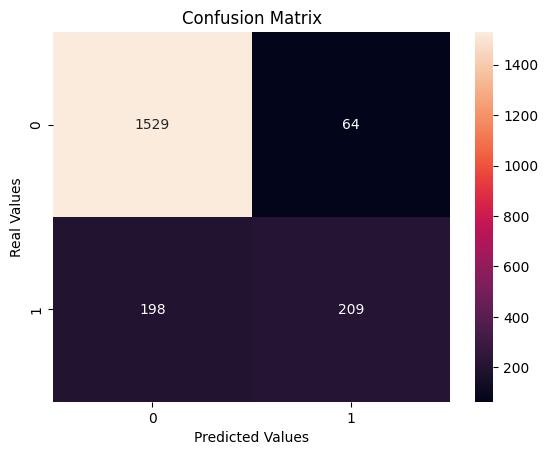

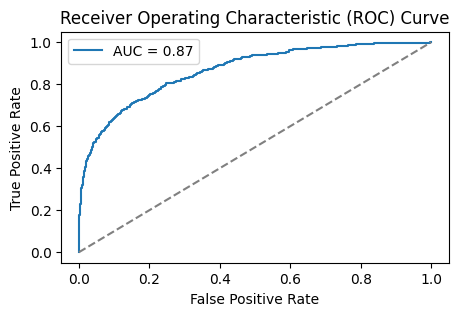

In [305]:
evaluate_classifier(y_test, final_predictions, probas)

The model's performance isn't in the best shape!

- **Recall (0.51)**: The model correctly identifies 51% of churners. In practical terms, when we examine the confusion matrix, it accurately predicts 209 out of 407 attrited customers.

- **Precision (0.77)**: Of all the customers predicted as churners, 77% of them indeed churn. In practical terms, according to the confusion matrix, out of 273 customers predicted as churners, 209 of them genuinely churn.

- **ROC-AUC (0.87)**: With an impressive ROC-AUC score of 0.87, the model exhibits medium discriminative capability between attrited and existing customers."

## Interpreting the model results with feature importances

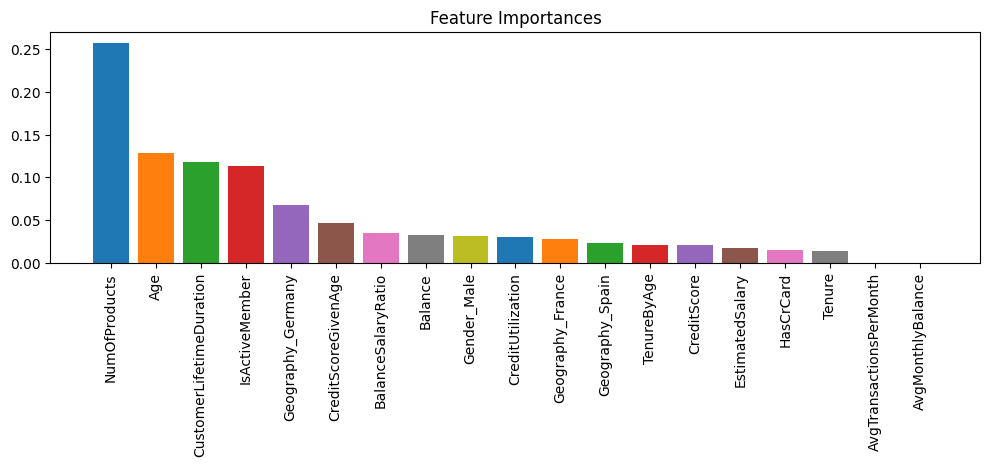

In [308]:
plot_feature_importances(final_model_par, X_train_prepared)

While ensemble models like XGBoost are typically less interpretable, we were able to gain insights and validate the estimator's outcomes by delving into feature importances. This analysis corroborated the findings from the Exploratory Data Analysis (EDA) phase, reaffirming that certain features distinctly contribute to distinguishing between attrited and existing customers.

## Visualizing some probabilities

In [310]:
predicted_probas = final_model_par.predict_proba(X_test_prepared)

In [311]:
probas_df = pd.concat([X_test, y_test], axis=1)
probas_df['churn_probas'] = predicted_probas[:, 1]
probas_df.sample(10, random_state=42)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,CustomerLifetimeDuration,AvgTransactionsPerMonth,CreditUtilization,AvgMonthlyBalance,BalanceVariation,Exited,churn_probas
2432,2433,15769064,Marshall,537,Germany,Male,39,3,135309.36,1,...,4.264552,0.076923,13.769231,46,0.021739,251.972737,2941.507826,NaN,1,0.414420
7455,7456,15748499,Johnson,550,Germany,Male,33,4,118400.91,1,...,8.457425,0.121212,16.666667,52,0.019231,215.274382,2276.940577,NaN,1,0.228139
5484,5485,15595842,Paramor,748,Germany,Male,45,2,119852.01,1,...,1.622825,0.044444,16.622222,40,0.025000,160.229960,2996.300250,NaN,1,0.744776
8963,8964,15796993,McCollum,741,France,Male,52,1,171236.30,2,...,7.842501,0.019231,14.250000,33,0.060606,231.088124,5188.978788,NaN,1,0.573385
4150,4151,15566295,Sanders,761,France,Female,33,6,138053.79,2,...,0.927909,0.181818,23.060606,52,0.038462,181.411025,2654.880577,NaN,0,0.095529
7596,7597,15794868,Nnonso,599,Germany,Male,40,10,137456.28,2,...,9.739617,0.250000,14.975000,45,0.044444,229.476260,3054.584000,NaN,0,0.139075
6590,6591,15674868,Wei,696,Spain,Female,30,0,0.00,2,...,0.000000,0.000000,23.200000,55,0.036364,0.000000,0.000000,NaN,0,0.046772
4648,4649,15751392,Fanucci,689,Spain,Female,57,4,0.00,2,...,0.000000,0.070175,12.087719,28,0.071429,0.000000,0.000000,NaN,1,0.469144
7211,7212,15690153,Sun,639,France,Female,37,4,116121.84,2,...,0.638556,0.108108,17.270270,48,0.041667,181.724319,2419.205000,NaN,0,0.115623
1166,1167,15633419,Brooks,622,Germany,Female,28,1,143124.63,2,...,1.751321,0.035714,22.214286,57,0.035088,230.103907,2510.958421,NaN,0,0.098985


## Financial results

- I will assess the model's impact on the bank's financial performance to demonstrate the project's value. To do this, I will analyze the confusion matrix and leverage our current data.

- While I don't have access to specific financial data to calculate exact gains, a common revenue source for credit card companies is the fees charged on outstanding balances, often referred to as the total revolving balance, carried by cardholders from month to month. Therefore, I will make the assumption that the bank charges a standard fee of 18% and use it as a basis for estimating financial gains.

- In order to estimate the financial impact of the model, I will consider the following costs and benefits:

  1. Retention Cost per Misclassified Client (False Positive):
   -  This cost applies to customers who are incorrectly labeled as churners by the model, even though they are not likely to churn. In such cases, the bank may incur expenses to retain these customers. To retain them, I will propose offering a discounted fee of 10% instead of the standard 18%, resulting in an 8% reduction in revenue due to the discount.

  2. Revenue Loss per Actual Churner Misclassified by the Model (False Negative):
    - This cost arises when customers who are genuinely at risk of churning are not correctly identified by the model. This leads to the bank losing both these customers and the associated revenue. This cost includes the entire 18% fee applied to the outstanding balances of these customers.

  3. Financial Gain from Correctly Predicted Churners (True Positive):
   - This gain occurs when the model accurately predicts a customer who is likely to churn. This enables the bank to retain these customers and the revenue they generate. Our retention strategy involves applying a 10% fee to their total revolving balances.

These considerations will help provide an estimate of the financial implications of the model's predictions for the bank's bottom line.

Getting a dataset for financial results.

In [313]:
financial_results = pd.concat([X_test, y_test], axis=1)[['Balance', 'Exited']]
financial_results['predicted'] = final_predictions

Getting separate datasets for false positives, false negatives and true positives costs and gain estimation.

In [315]:
fp_data = financial_results.loc[(financial_results['Exited'] == 0) & (financial_results['predicted'] == 1)]
fn_data = financial_results.loc[(financial_results['Exited'] == 1) & (financial_results['predicted'] == 0)]
tp_data = financial_results.loc[(financial_results['Exited'] == 1) & (financial_results['predicted'] == 1)]

Estimating the costs and gain.

In [316]:
fp_data['fp_cost'] = fp_data['Balance']*1.18 - fp_data['Balance']*1.10
fn_data['fn_cost'] = fn_data['Balance']*1.18
tp_data['tp_gain'] = tp_data['Balance']*1.10

Finally, the financial result given by the model will be the difference between the gain and the costs.

In [317]:
financial_gain = tp_data['tp_gain'].sum() - fp_data['fp_cost'].sum() - fn_data['Balance'].sum()
print(f'The model provides a financial gain of: ${financial_gain}')

The model provides a financial gain of: $4089987.911600001


Impressive! Our model indicates a projected financial outcome of roughly $4,089,987. The precise amount will ultimately hinge on the bank's strategic decisions when implementing customer retention strategies based on predicted churn probabilities. For instance, if the bank opts for a more conservative approach, aiming to minimize expenses linked to false positives, it can concentrate efforts on customers with higher churn probabilities, thereby adjusting the potential gain accordingly. Nonetheless, for estimation and foundational purposes, we have established that the project holds significant value.

# Evaluating all data

In [330]:
X_all_data = pd.concat([X_train_prepared, X_test_prepared], axis=0)
y_all_data = pd.concat([y_train, y_test], axis=0)

In [347]:
final_predictions = final_model_par.predict(X_all_data)

In [349]:
probas = final_model_par.predict_proba(X_all_data)[:, 1]

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      7963
           1       0.81      0.47      0.59      2037

    accuracy                           0.87     10000
   macro avg       0.84      0.72      0.76     10000
weighted avg       0.86      0.87      0.85     10000



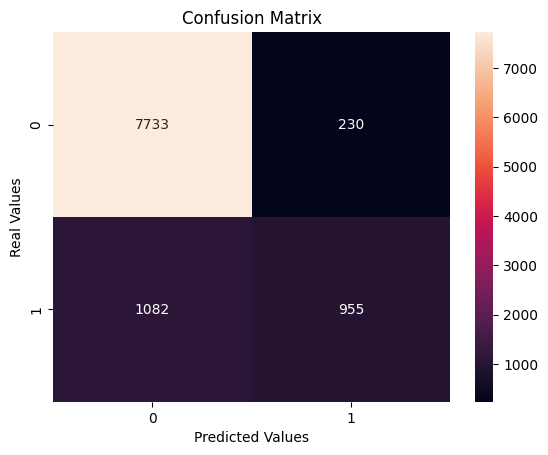

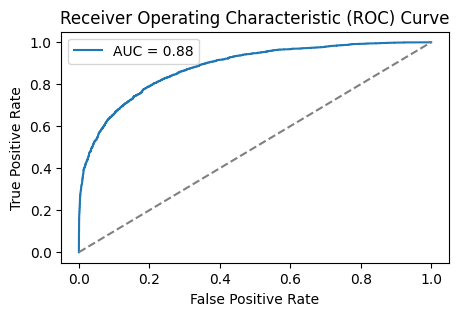

In [350]:
evaluate_classifier(y_all_data, final_predictions, probas)